### Attacks

Our implementation inludes three black-box patch attacks: Texture-based Patch Attack (TPA), MonoChrome Patch Attack (MPA) in our [paper](https://arxiv.org/abs/2004.05682); Metropolis-Hastings Attack (HPA) originally proposed in [paper](http://www.bmva.org/bmvc/2016/papers/paper137/index.html). Besides, we also implement the white-box patch attack: Adversarial Patch Attack (AP) orginally proposed in [paper](https://arxiv.org/abs/1712.09665).
You can add the path to the folder 'PatchAttack' in this repository to PYTHONPATH in your local system, and use 'PatchAttack' as a package. 

+ PatchAttack_tutorial.ipynb explains how to perform these attacks. The prerequisite of running this tutorial is to download the text file of [ImageNet_clsidx_to_labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) to the root directory of this repository. Please refer to the notebook for details. 

In [27]:
import os

from torchvision.models import ResNet, ResNet50_Weights

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [28]:
import numpy as np
import torch
import torchvision
import torchvision.models as Models
import torchvision.transforms as Transforms
from PIL import Image
import urllib.request

In [29]:
import PatchAttack.PatchAttack_attackers as PA
from PatchAttack import utils
from PatchAttack.PatchAttack_config import configure_PA

# Load model and images

In [30]:
with open(os.path.join('./ImageNet_clsidx_to_labels.txt')) as file:
    lines = file.readlines()
human_readable_labels = [line.split("'")[1] for line in lines]

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device).eval() # use your custom model here

In [32]:
preprocess = Transforms.Compose([
    Transforms.Resize(256),
    Transforms.CenterCrop(224),
    Transforms.ToTensor(),
    utils.data_agent.normalize,
])

In [33]:
image_dir = 'Images'
image_file = 'electric_locomotive_547.JPEG'
index = 0 # I specify this image corresponds to index 0, which relates to the dir to save the result
image= Image.open(os.path.join(image_dir, image_file))
label = int(image_file.split('_')[-1].split('.')[0])

In [34]:
input_tensor = preprocess(image).cuda()
label_tensor = torch.LongTensor([label]).cuda()

pred: 547__electric locomotive


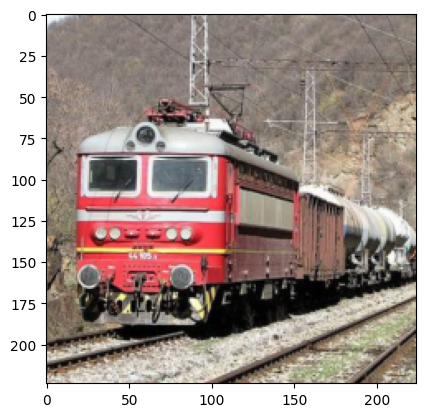

In [35]:
utils.data_agent.show_image_from_tensor(input_tensor, inv=True) # inv means inver normalize
with torch.no_grad():
    pred = model(input_tensor.unsqueeze(0)).argmax(dim=1).item()
    print('pred: {}__{}'.format(pred, human_readable_labels[pred]))

# PatchAttack: TPA, MPA, HPA, AP

In [36]:
dir_title = 'PatchAttack_tutorial' # used to form the path where the results are saved

There are demos of the texture dictionary 'TextureDict_demo' and adversarial patch dictionary 'AdvPatchDict_demo', each of which consists of 2 classes: 45 (Gila monster, Heloderma suspectum), 723 (pinwheel). Feel free to change the target in the flollowing code to see different adversarial images with different targets in targetted settings.

# TPA

In [37]:
# configure PA_cfg
configure_PA(
    t_name='TextureDict_demo', # texture dictionary dir
    t_labels=np.arange(1000).tolist(), # all the labels in Dict, start from 0 and continuous
    target=True, # targetted or non-targetted attack
    area_occlu=0.035, # area of each patch
    n_occlu=1, # need to set to be 1 in TPA
    rl_batch=500, steps=50,
    TPA_n_agents=10 # maximum number of patches allowed in TPA
)

USEFUL INFO:

TPA attacker will automatically check whether this image has been attacked before, and load the previous results
if available. For example, if you finished attacking the image with TPA_n_agent=6, when you attack this image
again with TPA_n_agent=3, no computation will be needed. Also, if you attack it again with TPA_n_agent=10,
TPA attacker will start from the results of TPA_n_agent=3.

If you want to utilize this feature of resuming, please make sure input_tensor, label_tensor, dir_title and
input_name are consistent.

All the results will be saved in './PatchAttack/TPA/...'

In [38]:
TPA = PA.TPA(dir_title)
adv_image, rcd_list = TPA.attack(
    model=model, 
    input_tensor=input_tensor, 
    label_tensor=label_tensor, 
    target=723, # For non targeted attack, use textures of a randonly chosen class
    input_name='{}'.format(index),
)

texture dictionary of label_723 is already built, loading...
target_723 | 30 texture images has been prepared!
not filtering the texture images
*** loaded pre_maximum_agents: 10
*** combos taken: 2 | non-target success: True | target success: True | queries: 20000 | 


In [39]:
combos = rcd_list[-1].combos[0] # all the actions RL agent has selected
area = TPA.calculate_area(adv_image, combos)
print('Area used: {:.4f}'.format(area))

Area used: 0.0670


pred: 723__pinwheel


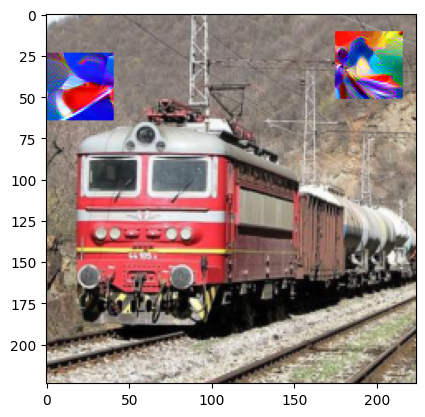

In [40]:
utils.data_agent.show_image_from_tensor(adv_image, inv=True)
with torch.no_grad():
    pred = model(adv_image.unsqueeze(0)).argmax(dim=1).item()
    print('pred: {}__{}'.format(pred, human_readable_labels[pred]))

# MPA

In [41]:
# configure PA_cfg
configure_PA(
    t_name='',
    t_labels=np.arange(1000).tolist(), # all the possible labels, start from 0 and continuous
    target=False, # targetted or non-targetted attack
    n_occlu=3, # number of patches superimposed whose size is optimized
    rl_batch=500, steps=50,
    MPA_color=True, # MPA_Gray or MPA_RGB
)

USEFUL INFO

MPA will automically check whether this image is attacked before with the same setting. 

If you want to utilize this feature of resuming, please make sure input_tensor, label_tensor, dir_title and
input_name are consistent.

All the results will be saved in './PatchAttack/MPA/...'

In [42]:
MPA = PA.MPA(dir_title)
adv_image, rcd = MPA.attack(
    model=model, 
    input_tensor=input_tensor, 
    label_tensor=label_tensor, 
    target=45, # For non-targetted attack, random number
    input_name='{}'.format(index),
)

*** non_target_success: [True] | target_success: [False] | queries: 18500.0000 | occluded area: 0.3209 | 


In [43]:
# rcd stores the area information here
# area = rcd.areas[0]
# However, we can still calculate one
area = MPA.calculate_area(adv_image, rcd.combos[0])
print('Area used: {:.4f}'.format(area))

Area used: 0.3209


The batch dimension has been squeezed
pred: 820__steam locomotive


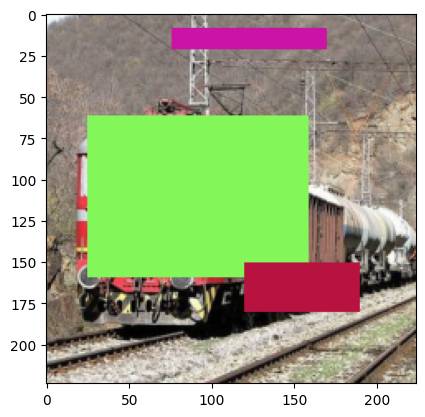

In [44]:
utils.data_agent.show_image_from_tensor(adv_image, inv=True)
with torch.no_grad():
    pred = model(adv_image).argmax(dim=1).item()
    print('pred: {}__{}'.format(pred, human_readable_labels[pred]))

# HPA

In [45]:
# configure PA_cfg
configure_PA(
    t_name='',
    t_labels=np.arange(1000).tolist(), # all the possible labels, start from 0 and continuous
    target=False, # targetted or non-targetted attack
    n_occlu=3, # number of patches superimposed whose size is optimized
    steps=10000, # query number, since it is a sampling method
    HPA_bs=1, # since HPA is very slow, batch mode is supported
)

USEFUL INFO

HPA will automically check whether this image is attacked before with the same setting. 

If you want to utilize this feature of resuming, please make sure input_tensor, label_tensor, dir_title are consistent. The indices_range deitermines how the results are saved. For example, if indices_range=(0, 3), the result for the 3 images are saved in the directories: ATTACK_DIRS/0/rcd.pt, ..., ATTACK_DIRS/2/rcd.pt.

All the results will be saved in './PatchAttack/HPA/...'

In [46]:
HPA = PA.HPA(dir_title)
adv_images, rcds = HPA.attack(
    model=model, 
    input_tensor=input_tensor.unsqueeze(0),  # batch inputs (bs, 3, H, W) is supported, here bs=1
    label_tensor=label_tensor, 
    target=[723], # For non-targetted attack, random number
    indices_range=(index,index+1),
)

1 previous results loaded...
*** Batch Size: 1 | non_target_success rate: 1.0000 | target_success rate: -1.0000 | avg_queries: 10000.0000 | avg_area_occluded: 0.7462 | 


In [47]:
masks = np.stack([item.mask for item in rcds], axis=0)
# calculate the area of each single input
areas = HPA.calculate_areas(adv_image, masks)
print('Areas used: {}'.format(areas))

Areas used: [0.7461934]


pred: 603__horse cart, horse-cart


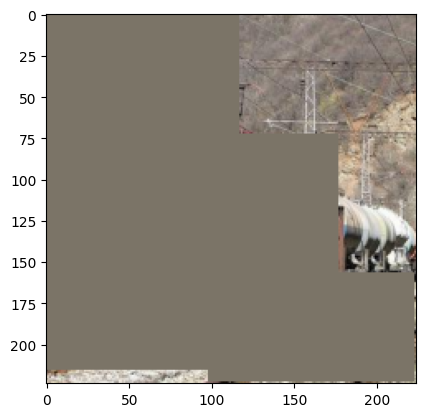

In [48]:
utils.data_agent.show_image_from_tensor(adv_images[0], inv=True)
with torch.no_grad():
    pred = model(adv_images[0].unsqueeze(0)).argmax(dim=1).item()
    print('pred: {}__{}'.format(pred, human_readable_labels[pred]))

# AP

In [49]:
# configure PA_cfg
configure_PA(
    t_name='AdvPatchDict_demo',
    t_labels=np.arange(1000).tolist(), # all the possible labels, start from 0 and continuous
)

USEFUL INFO

AP will automically check whether this image is attacked before with the same setting. 

If you want to utilize this feature of resuming, please make sure input_tensor, label_tensor, dir_title and
input_name are consistent.

All the results will be saved in './PatchAttack/AP/...'


In [50]:
AP = PA.AP(dir_title)
adv_image, rcd = AP.attack(
    model=model,
    input_tensor=input_tensor.unsqueeze(0),
    label_tensor=label_tensor,
    target=45, # targetted and non-targetted attack are same for AP
    input_name='{}'.format(index),
)

AdvPatch of label_45 is already built, loading...
Previous result loaded:
*** non_target_success: [False] | target_success: [False] | occluded area: 0.0895 | 


In [51]:
# rcd stores the masks which can be used to calculate areas
area = AP.calculate_area(adv_image, rcd.masks[0])

The batch dimension has been squeezed
pred: 547__electric locomotive


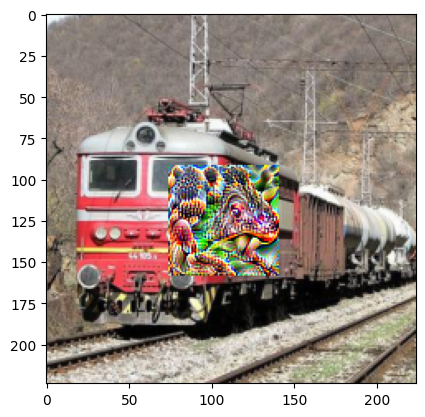

In [52]:
utils.data_agent.show_image_from_tensor(adv_image, inv=True)
with torch.no_grad():
    pred = model(adv_image).argmax(dim=1).item()
    print('pred: {}__{}'.format(pred, human_readable_labels[pred]))

The AP example here uses the patch occupying 8.95% of the whole image, you can generate AdvPatchDict consisting of patches of different sizes by adjusting parameters in PatchAttack/PatchAttack_config.py and running main_build-dict.py

AdvPatch generated from VGG19 is effective to attack VGG19, but not effective to attack networks with other architectures like ResNet50, DenseNet121,...
Please perform experiments on large set of images to see this.